# Digit Recognizer

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision, as the description of <a href= https://www.kaggle.com/c/digit-recognizer>Digit Recognizer Challenge</a> mentions. 

In this notebook, our goal is to identify digits from dataset of handwritten images (Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total).

Let's get started!

In [ ]:
import numpy as np
import pandas as pd
from keras import backend as K
K.set_image_dim_ordering('th')
import matplotlib.pyplot as plt
%matplotlib inline

<h3> 1. LOAD DATA (TRAIN AND TEST) </h3>

Download the data from <a href=https://www.kaggle.com/c/digit-recognizer/data> Competetion's web page </a>.

A. <b>TRAINING DATA</b>: Training data consists of images (handwritten digits of size 28 X 28) and labels (the digit corresponding to this image, a number between 0-9).<br>
B. <b>TEST DATA</b>: Test data consists of images (handwritten digits of size 28 X 28). We need to predict labels for this test data.

In [139]:
# load training data
train_data = pd.read_csv('./train.csv')
print("Training data shape: "+ str(train_data.shape))
train_data.head()

Training data shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
# load test data
test_data = pd.read_csv('./test.csv')
print("Test data shape: " + str(test_data.shape))
test_data.head()

Test data shape: (28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
#Get train data pixel values and labels (i.e. digits)
X_train = (train_data.iloc[:,1:].values).astype('float32') # pixel values(the columns with heading pixel 0 to pixel 783 above )
Y_train = train_data.iloc[:,0].values.astype('int32') # target labels(the column with heading "label" above)

#Get test data pixel values 
X_test = test_data.values.astype('float32')

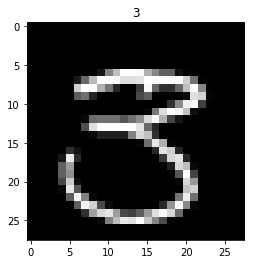

In [142]:
#Convert train data to format - (num_images, img_rows, img_cols)  
X_train = X_train.reshape(X_train.shape[0], 28, 28)

#lets Plot a train image
plt.imshow(X_train[7], cmap=plt.get_cmap('gray'))
plt.title(Y_train[7]);

In [143]:
#For colour channel gray, we need to expand one more dimension as 1 for both X_train and X_test
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

print("X_train data shape: "+ str(X_train.shape))
print("X_test data shape: " + str(X_test.shape))

X_train data shape: (42000, 1, 28, 28)
X_test data shape: (28000, 1, 28, 28)


<h3> 2. Preprocessing the data </h3>

A. <b>Mean subtraction</b> is the most common form of preprocessing. It involves subtracting the mean across every individual feature in the data, and has the geometric interpretation of centering the cloud of data around the origin along every dimension

B. <b>Normalization</b> refers to normalizing the data dimensions so that they are of approximately the same scale. To achieve this simplest way is to divide each dimension by its standard deviation, once it has been zero-centered

For more on Data Pre-processing, I would sggest reading through <a href = http://cs231n.github.io/neural-networks-2/#datapre>this</a>.

In [ ]:
#Calculate Mean of training data
mean_x = X_train.mean().astype(np.float32)
#Calculate Std deviation of training data
std_x = X_train.std().astype(np.float32)

In [144]:
def standardize(x):
    '''
    Function to subtract mean from x to zero center x. 
    Then divide the zero centered x by std deviation of x.
    '''
    return (x-mean_x)/std_x

In [145]:
#Stadardise train data
X_train = standardize(X_train)

<h3>3. One Hot Encoding of labels</h3>

One hot encoding is a representation of categorical variables as binary vectors.

This first requires that the categorical values be mapped to integer values. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

For example, in our case, we have labels as digits from 0 to 9. Let's say, we are interested in label 6 (i.e. digit 6). <b>One hot encoding for digit 6 is [0,0,0,0,0,0,1,0,0,0]</b>, i.e. 0 at all the indices except for the index corresponding to digit 6.


Index Numberings:    [0,1,2,3,4,5,6,7,8,9] <br>
One-hot Encoding: [0,0,0,0,0,0,1,0,0,0]


In [146]:
#ONE HOT ENCODING OF LABELS
from keras.utils import np_utils

Y_train= np_utils.to_categorical(Y_train)
num_classes = Y_train.shape[1]
print(num_classes)

10


<h1> DESIGN NEURAL NETWORK </h1>

In [147]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)

<h3> 4. About Train, Validation and Test Splits </h3>

A. <b>Training set</b>: A set of examples used for learning, i.e. to fit the parameters of the classifier.<br>
B. <b>Validation set</b>: A set of examples used to tune the parameters of a classifier.<br>
C. <b>Test set</b>: A set of examples used only to assess the performance of a fully-trained classifier. We would use the test set to estimate the error rate after we have chosen the final model.<br>

<b>Why separate test and validation sets?</b> <br>
The validation set is used to select the final model, so error rate estimate of the final model on validation data will be biased (smaller than the true error rate). After selecting a model with help of validation set, we assess the final model on the test set, WE MUST NOT tune the model any further!

In [148]:
from sklearn.model_selection import train_test_split

# divide data into training and validation set
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.15, random_state=80)

print('train_features shape: ', X_train.shape)
print('vali_features shape: ', X_validation.shape)
print('train_labels shape: ', Y_train.shape)
print('vali_labels shape: ', Y_validation.shape)

('train_features shape: ', (35700, 1, 28, 28))
('vali_features shape: ', (6300, 1, 28, 28))
('train_labels shape: ', (35700, 10))
('vali_labels shape: ', (6300, 10))


<h3>5. Build your model </h3>

Stack the layers for your network. (We can also use pretrained models!)

In [164]:
from keras.models import Sequential
from keras.layers import Activation, Flatten, Reshape, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

# hyperparameters
epochs = 10
batch_size = 256 #Preferrably keep it a multiple fo 2

# build the model
num_classes = 10
model = Sequential()
#MODEL 1: Following model gives val_acc: 0.9875
#model.add(Conv2D(64, (5, 5), input_shape=(1, 28, 28), activation='relu', bias_initializer='RandomNormal'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(128, (5, 5), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(num_classes, activation='softmax'))

#MODEL 2: Following model gives val_acc: 0.9894
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(1, 28, 28), bias_initializer='RandomNormal'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [165]:
#Lets print the model we have created!
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 24, 24)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 12, 12)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 12, 12)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
__________

<h3>6. Compile and Train your model! </h3>

A. <b>COMPILE your model</b>: While compiling the model, we have to make three choices:<br>
<ul style="list-style-type:disc">
  <li><b>Optimizer</b>: This is how the update steps are performed. Here I have chosen adam, there are many other choices for optimisers. <br></li>
  <li><b>Loss</b>: Loss is basically measure of our happiness with the results(or of how good the network si doing). <br>
</li>
  <li><b>Metrics</b>: Metrics is used to monitor the performance of the network. <br></li>
</ul>
 
B. <b>TRAIN your model</b>: We can choose the number of epochs(i.e. how long do we want to train for)

In [166]:
from keras.optimizers import Adam

model.compile(optimizer='adam',  #Updates the network
              loss='categorical_crossentropy', #Measure of how good network is doing
               metrics=['accuracy']) #Monitor for performance of network

In [167]:
# training
training = model.fit(X_train, Y_train,
                     validation_data=(X_validation, Y_validation),
                     epochs=epochs,
                     batch_size=batch_size, 
                     verbose=1)

Train on 35700 samples, validate on 6300 samples
Epoch 1/10
35700/35700 [==============================] - 323s - loss: 0.3650 - acc: 0.8829 - val_loss: 0.0792 - val_acc: 0.9751
Epoch 2/10
35700/35700 [==============================] - 327s - loss: 0.1092 - acc: 0.9675 - val_loss: 0.0604 - val_acc: 0.9803
Epoch 3/10
35700/35700 [==============================] - 328s - loss: 0.0774 - acc: 0.9766 - val_loss: 0.0510 - val_acc: 0.9837
Epoch 4/10
35700/35700 [==============================] - 313s - loss: 0.0601 - acc: 0.9816 - val_loss: 0.0497 - val_acc: 0.9859
Epoch 5/10
35700/35700 [==============================] - 323s - loss: 0.0499 - acc: 0.9843 - val_loss: 0.0479 - val_acc: 0.9863
Epoch 6/10
35700/35700 [==============================] - 312s - loss: 0.0435 - acc: 0.9861 - val_loss: 0.0481 - val_acc: 0.9857
Epoch 7/10
35700/35700 [==============================] - 305s - loss: 0.0383 - acc: 0.9876 - val_loss: 0.0461 - val_acc: 0.9873
Epoch 8/10
35700/35700 [========================

<h3>7. Plot Loss and Accuracy (For training and validation data) </h3>

In general, training and validation loss and accuracy gives a clear insight into the situation when we are overfitting or when we should stop training.

In [172]:
#Lets plot loss and accuracy for training as well as validation!
def plot_model_history(model_history):
    '''
    Function to plot trainging and validation loss and accuracy
    input: model_history, Model History
    '''
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    # Accuracy for both training and validation
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['trainining', 'validation'], loc='best')
    # Loss for both training and validation
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['trainining', 'validation'], loc='best')
    plt.show()

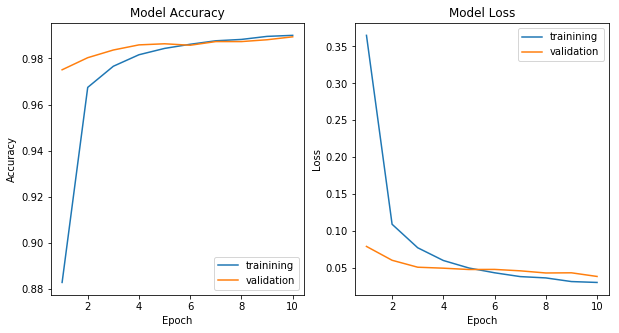

In [173]:
plot_model_history(training)

<h3>8. Make predictions on Test data</h3>

A. Use the trained model to make predictions on test data. [<b>NOTE</b> : test data is standardised with mean and std deviation of training data!]<br>
B. We get probabilities as predictions. So, we choose the index of highest probability as our predicted digit.

In [174]:
# ZERO MEAN and UNIT STD DEV for test images as well
X_test = standardize(X_test)

# Lets predict labels for test set!
Y_prediction = model.predict(X_test, batch_size=batch_size, verbose=1)

# Pick the predicted class with highest probability to convert from probabilities to digits!!
Y_prediction_digits = np.argmax(Y_prediction, axis=1)

28000/28000 [==============================] - 126s   


<h3>9. Let's submit our model </h3>

In [175]:
submission = pd.DataFrame({'Label': Y_prediction_digits})
submission.index += 1
submission.index.name = "ImageId"
submission.to_csv('submission_public.csv')